In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/names/names/female.txt
/kaggle/input/names/names/README
/kaggle/input/names/names/male.txt


In [2]:
import torch
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn, optim, cuda
from torch.nn import functional as F
from torch.utils import data as torch_data
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tqdm import tqdm

fig_size = plt.rcParams['figure.figsize']
device = 'cuda' if cuda.is_available() else 'cpu'
if device == 'cuda':
    print(f"Torch using {cuda.get_device_name()}")
else:
    print(f"Torch using {device}")

warnings.filterwarnings('ignore')
torch.manual_seed(0)
np.random.seed(0)

%matplotlib inline

Torch using Tesla P100-PCIE-16GB


In [3]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
! export CUDA_LAUNCH_BLOCKING=1

In [5]:
MALE_FILE = "/kaggle/input/names/names/male.txt"
FEMALE_FILE = "/kaggle/input/names/names/female.txt"

## Creating a dataframe from the text files

In [6]:
names_df = pd.DataFrame(columns=["name", "gender"])

with open(MALE_FILE, mode='r') as f:
    for line in f:
        name = line[:-1] if line.endswith('\n') else line        
        names_df.loc[names_df.shape[0], :] = (name, "male")

with open(FEMALE_FILE, mode='r') as f:
    for line in f:
        name = line[:-1] if line.endswith('\n') else line        
        names_df.loc[names_df.shape[0], :] = (name, "female")

names_df.name = names_df.name.str.lower()
puncts = "' -"
table = str.maketrans(dict.fromkeys(puncts))
names_df.name = names_df.name.str.translate(table)

female    5001
male      2943
Name: gender, dtype: int64


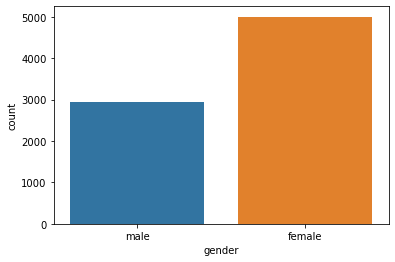

In [7]:
female_count = names_df.gender.value_counts().female
male_count = names_df.gender.value_counts().male

# print(f"Female Count: {female_count}\nMale Count: {male_count}")
print(names_df.gender.value_counts())
_ = sns.countplot(x='gender', data=names_df)

We see that the number of male names and female names are imbalanced. To keep the classes balanced, I will randomly select names from each class to balance the class distribution.

female    0.629532
male      0.370468
Name: gender, dtype: float64


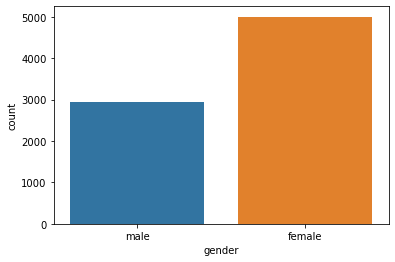

In [8]:
min_count = min(female_count, male_count)
male_df = names_df.loc[names_df.gender == 'male'].sample(n=min_count)
female_df = names_df.loc[names_df.gender == 'female'].sample(n=min_count)

# names_balanced = pd.concat([male_df, female_df]).sample(frac=1).reset_index().drop(["index"], axis=1)
names_balanced = names_df.copy()
print(names_balanced.gender.value_counts(normalize=True))
_ = sns.countplot(x='gender', data=names_balanced)

## Utilities

In [9]:
class_dict = {
    'female': 0,
    'male': 1
}

rev_class_dict = {val: key for key, val in class_dict.items()}


class History:
    def __init__(self, losses, accs, val_losses=None, val_accs=None):
        self.loss = losses
        self.accuracy = accs
        self.val_loss = val_losses
        self.val_accuracy = val_accs
    
    def __getitem__(self, val):
        return getattr(self, val)


def get_vocab(names):
    vocab = set()
    maxlen = 0
    for name in names:
        vocab.update(name)
        maxlen = max(maxlen, len(name))
    
    vocab.add('<PAD>')
    return sorted(vocab), maxlen


def pad_and_index(mapping, max_len):
    def inner(x):
        pad_length = max_len - len(x)
        new_name = [mapping['<PAD>']] * pad_length
#         new_name = []
        
        for char in x:
            new_name.append(mapping[char])
        
        return new_name
    return inner


def preprocess(df, mapping, max_len, test_size=0.2):
    df = df.copy().sample(frac=1)
    df["name_indexed"] = df.name.apply(pad_and_index(mapping, max_len))
    df["gender_labelled"] = df.gender.apply(lambda x: 0 if x == 'female' else 1)
    
    if not (0 <= test_size <= 1):
        raise ValueError(f"test_size must be float between 0 and 1. Got {test_size}")
    
    # split into train and test
    X = df.name_indexed.values
    y = df.gender_labelled.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size)
    
    # calculate class weights
    class_weights = [(y_train == 0).sum(), (y_train == 1).sum()]
    class_weights = [sum(class_weights) / weight for weight in class_weights]
    
    train_df = pd.DataFrame({
        'name_indexed': X_train,
        'gender_labelled': y_train
    })
    
    test_df = pd.DataFrame({
        'name_indexed': X_test,
        'gender_labelled': y_test
    })
    
    return train_df, test_df, class_weights


def fix_array(arr):
    x_ = []
    for row in arr:
        x_.append(row)

    return np.array(x_)

In [10]:
def train_epoch(model, optimizer, loss_func, loader, return_attention):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    
    for i, (features, labels) in enumerate(loader):
        total += labels.size(0)
        
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        if return_attention:
            output, _ = model(features)
        else:
            output = model(features)

        loss = loss_func(output, labels)

        _, predicted = torch.max(output, axis=-1)
        
        epoch_acc += (predicted == labels).sum().item()
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    return epoch_loss / total, epoch_acc / total


def eval_epoch(model, loss_func, loader, return_attention):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    
    with torch.no_grad():
        for i, (features, labels) in enumerate(loader):
            total += labels.size(0)

            features = features.to(device)
            labels = labels.to(device)

            if return_attention:
                output, _ = model(features)
            else:
                output = model(features)
            loss = loss_func(output, labels)

            _, predicted = torch.max(output, axis=-1)

            epoch_acc += (predicted == labels).sum().item()
            epoch_loss += loss.item()
    
    return epoch_loss / total, epoch_acc / total


def train(model, optimizer, loss, train_loader, val_loader=None, epochs=1, return_attention=False):
    losses = []
    accs = []
    val_losses = [] if val_loader else None
    val_accs = [] if val_loader else None
    
    for epoch in range(1, epochs + 1):
        l, a = train_epoch(model, optimizer, loss, train_loader, return_attention)
        losses.append(l)
        accs.append(a)
        
        if val_loader:
            val_l, val_a = eval_epoch(model, loss, val_loader, return_attention)
            val_losses.append(val_l)
            val_accs.append(val_a)

        print(f"Epoch: {epoch}")
        print(f"\tLoss: {l:.3f}")
        if val_loader:
            print(f"\tVal Loss: {val_l:.3f}")
        print(f"\tAccuracy: {a * 100:.2f}%")
        if val_loader:
            print(f"\tVal Accuracy: {val_a * 100:.2f}%")

    return History(losses, accs, val_losses=val_losses, val_accs=val_accs)

## Build vocabulary and char-int mappings

In [11]:
vocab, maxlen = get_vocab(names_balanced.name)

# integer to string
char_itos = dict(enumerate(vocab))

# string to integer
char_stoi = {val: key for key, val in char_itos.items()}

hidden_nodes = int(2 / 3 * (maxlen * len(char_itos.keys())))
print(hidden_nodes)

252


In [12]:
char_stoi

{'<PAD>': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

## Preprocess the dataframe

In [13]:
train_df, test_df, class_weights = preprocess(names_df, char_stoi, maxlen, test_size=0.25)
print(train_df.gender_labelled.value_counts())
print(test_df.gender_labelled.value_counts())

0    3751
1    2207
Name: gender_labelled, dtype: int64
0    1250
1     736
Name: gender_labelled, dtype: int64


In [14]:
train_df

,name_indexed,gender_labelled
0,"[0, 0, 0, 0, 0, 0, 0, 0, 11, 9, 18, 2, 5, 5]",0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 25, 12, 5]",0
2,"[0, 0, 0, 0, 0, 0, 13, 1, 18, 18, 9, 12, 5, 5]",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 2, 18, 9, 20, 14, 9]",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 7, 21, 19, 20, 9, 5]",0
...,...,...
5953,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 12, 9, 8, 21]",1
5954,"[0, 0, 0, 0, 0, 0, 0, 1, 5, 18, 9, 5, 12, 1]",0
5955,"[0, 0, 0, 0, 0, 0, 0, 16, 1, 20, 18, 9, 3, 11]",1
5956,"[0, 0, 0, 0, 0, 0, 0, 0, 16, 9, 5, 18, 3, 5]",1


In [15]:
test_df

,name_indexed,gender_labelled
0,"[0, 0, 0, 0, 0, 0, 0, 11, 18, 9, 19, 20, 1, 12]",0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 12, 12, 5, 12]",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 11, 1, 12, 22, 9, 14]",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 21, 19, 25]",0
4,"[0, 0, 0, 0, 0, 0, 13, 1, 18, 19, 8, 1, 12, 12]",1
...,...,...
1981,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 5, 12, 1, 8]",0
1982,"[0, 0, 0, 0, 0, 0, 0, 0, 11, 15, 18, 14, 5, 25]",0
1983,"[0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 12, 1, 18, 4]",1
1984,"[0, 0, 0, 0, 0, 11, 1, 19, 19, 1, 14, 4, 18, 1]",0


## Create a Dataset and DataLoader

In [16]:
# Creating a Dataset class for the dataset
class NamesDataset(torch_data.Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        input_seq = self.df.name_indexed[idx]
        return torch.tensor(input_seq), torch.tensor(self.df.gender_labelled[idx])


# Creating a data loader to feed to the model
names_loader_train = torch_data.DataLoader(NamesDataset(train_df), batch_size=32, shuffle=True)
names_loader_test = torch_data.DataLoader(NamesDataset(test_df), batch_size=32, shuffle=True)

### Building the LSTM+Attention model
This attention layer was devised by Winata et. al. in this [paper](https://arxiv.org/pdf/1805.12307.pdf).

In [17]:
class Attention(nn.Module):
    def __init__(self, in_features, *args, bias=True, **kwargs):
        super(Attention, self).__init__(*args, **kwargs)
        self.bias = bias
        self.W = nn.Parameter(torch.randn(in_features, in_features))
        if self.bias:
            self.b = nn.Parameter(torch.randn(in_features))
        self.u = nn.Parameter(torch.randn(in_features))
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        uit = torch.matmul(x, self.W)
        if self.bias:
            uit += self.b
        ait = torch.matmul(self.tanh(uit), self.u)
        attention = self.softmax(ait)
        return attention

In [18]:
class GenderClassifierWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, embed_size, *args, **kwargs):
        super(GenderClassifierWithAttention, self).__init__(*args, **kwargs)
        self.hid_dim = hidden_size
        
        # embedding layer
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embed_size)
        
        # attention layer
        self.attention = Attention(self.hid_dim * 2)
        
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size=self.hid_dim, num_layers=2, bidirectional=True, batch_first=True)
        
        # dropout layers
        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p=0.4)
        
        # normalization layers
        self.batch_norm1 = nn.BatchNorm1d(num_features=15)
        self.batch_norm2 = nn.BatchNorm1d(num_features=7)
        self.layer_norm = nn.LayerNorm(40)
        
        # linear layers
        self.fc1 = nn.Linear(in_features=self.hid_dim * 2, out_features=15)
        self.fc2 = nn.Linear(in_features=15, out_features=7)
        self.fc3 = nn.Linear(in_features=7, out_features=2)
        
        # activation functions
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.embedding(x).float()
        
        out, (h, c) = self.lstm(x)
        out = self.layer_norm(out)
        attention = self.attention(self.tanh(out))
        x = torch.einsum('ijk,ij->ik', out, attention)
        
        x = self.tanh(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        
        x = self.tanh(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x, attention

In [19]:
lstm_attention = GenderClassifierWithAttention(input_size=len(char_stoi.keys()), hidden_size=20, embed_size=30).to(device)
# print(sum(p.numel() for p in lstm_attention.parameters()))
optim_adam = optim.Adam(lstm_attention.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
history = train(lstm_attention, optim_adam, criterion, names_loader_train, val_loader=names_loader_test, epochs=100, return_attention=True)
torch.save(lstm_attention, 'lstm_attention.pt')

Epoch: 1
	Loss: 0.024
	Val Loss: 0.020
	Accuracy: 58.71%
	Val Accuracy: 70.04%
Epoch: 2
	Loss: 0.023
	Val Loss: 0.019
	Accuracy: 61.28%
	Val Accuracy: 71.55%
Epoch: 3
	Loss: 0.021
	Val Loss: 0.018
	Accuracy: 64.99%
	Val Accuracy: 74.12%
Epoch: 4
	Loss: 0.020
	Val Loss: 0.017
	Accuracy: 67.07%
	Val Accuracy: 75.73%
Epoch: 5
	Loss: 0.018
	Val Loss: 0.016
	Accuracy: 71.38%
	Val Accuracy: 77.09%
Epoch: 6
	Loss: 0.018
	Val Loss: 0.015
	Accuracy: 72.68%
	Val Accuracy: 77.84%
Epoch: 7
	Loss: 0.017
	Val Loss: 0.015
	Accuracy: 73.90%
	Val Accuracy: 77.84%
Epoch: 8
	Loss: 0.016
	Val Loss: 0.015
	Accuracy: 76.02%
	Val Accuracy: 77.19%
Epoch: 9
	Loss: 0.016
	Val Loss: 0.015
	Accuracy: 77.32%
	Val Accuracy: 78.05%
Epoch: 10
	Loss: 0.016
	Val Loss: 0.014
	Accuracy: 77.14%
	Val Accuracy: 77.19%
Epoch: 11
	Loss: 0.015
	Val Loss: 0.014
	Accuracy: 77.29%
	Val Accuracy: 78.30%
Epoch: 12
	Loss: 0.015
	Val Loss: 0.015
	Accuracy: 78.13%
	Val Accuracy: 77.95%
Epoch: 13
	Loss: 0.015
	Val Loss: 0.014
	Accuracy

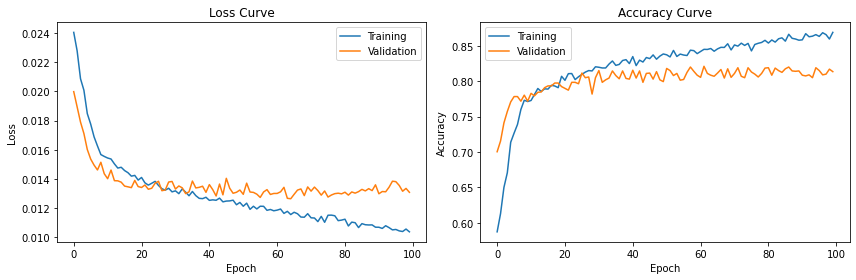

In [20]:
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))

_ = ax[0].plot(range(len(history.loss)), history.loss)
if history.val_loss:
    _ = ax[0].plot(range(len(history.val_loss)), history.val_loss)
    _ = ax[0].legend(['Training', 'Validation'])
_ = ax[0].set(xlabel="Epoch", ylabel="Loss", title="Loss Curve")
_ = ax[1].plot(range(len(history.accuracy)), history.accuracy)
if history.val_accuracy:
    _ = ax[1].plot(range(len(history.val_accuracy)), history.val_accuracy)
    _ = ax[1].legend(['Training', 'Validation'])
_ = ax[1].set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy Curve")
_ = plt.tight_layout()

## Evaluate and compute metrics on test set

Accuracy: 81.37%
Precision: 0.725
Recall: 0.800
F1 Score: 0.761
AUC: 0.903


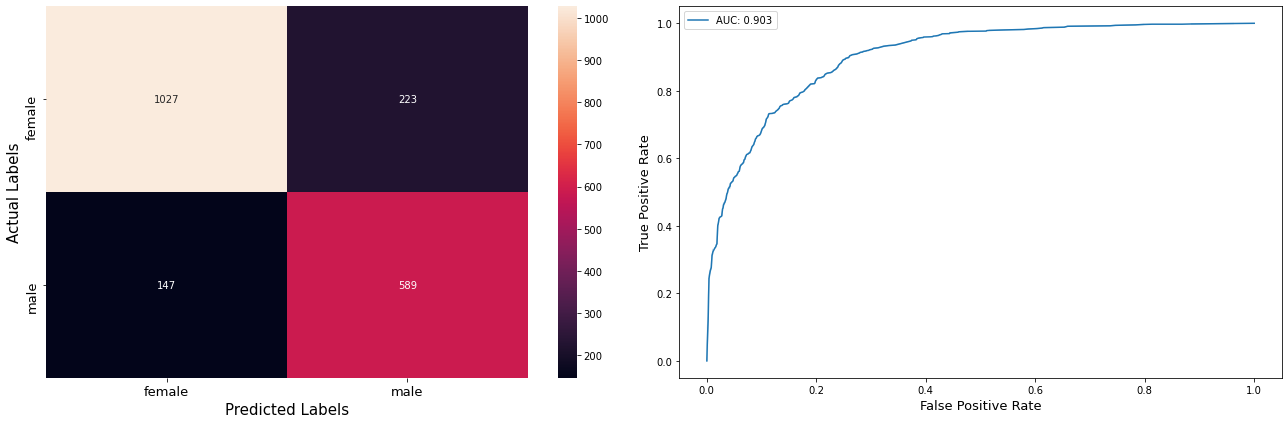

In [21]:
lstm_attention.eval()
y_true = test_df.gender_labelled.values

y_outputs = [
    F.softmax(
        lstm_attention(
            torch.reshape(torch.tensor(test_df.name_indexed.values[i]).to(device), (1, -1))
        )[0].detach(), dim=-1) for i in range(test_df.shape[0])
]

y_pred_proba = [
    vec.squeeze().cpu().detach().numpy().tolist()[1] for vec in y_outputs
]

y_pred = torch.tensor([
    torch.max(vec, axis=-1)[1] for vec in y_outputs
])

# compute metrics on test set
accuracy = (y_pred == torch.tensor(y_true)).sum().item() / test_df.shape[0]
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_proba)
auc_score = metrics.auc(fpr, tpr)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")
print(f"AUC: {auc_score:.3f}")

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * 1.5 * ncols, fig_size[1] * 1.5 * nrows))
_ = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax[0])
_ = ax[0].set_xticklabels(["female", "male"], fontsize=13)
_ = ax[0].set_yticklabels(["female", "male"], fontsize=13)
_ = ax[0].set_xlabel("Predicted Labels", fontsize=15)
_ = ax[0].set_ylabel("Actual Labels", fontsize=15)
_ = sns.lineplot(fpr, tpr, ax=ax[1], label=f"AUC: {auc_score:.3f}")
_ = ax[1].set_xlabel("False Positive Rate", fontsize=13)
_ = ax[1].set_ylabel("True Positive Rate", fontsize=13)
_ = plt.tight_layout()

Plotting the attention components of randomly sampled examples

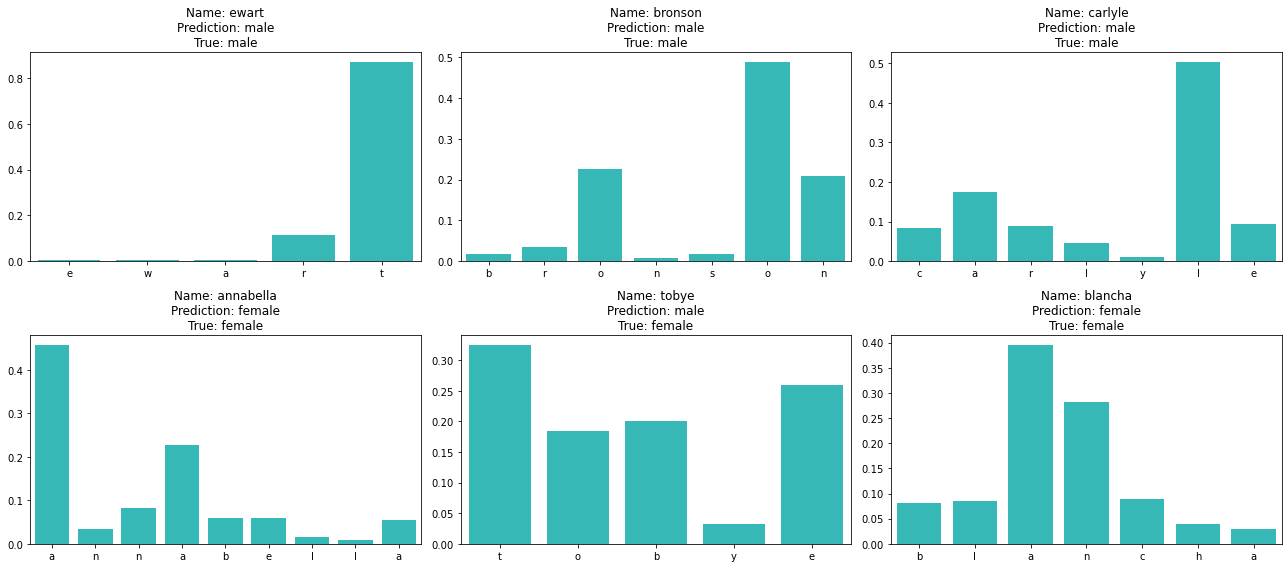

In [22]:
# randomly sample names from each gender
samples_per_gender = 3
male_sample_names = names_df.loc[names_df.gender == 'male', :].sample(n=samples_per_gender).name.values.tolist()
female_sample_names = names_df.loc[names_df.gender == 'female', :].sample(n=samples_per_gender).name.values.tolist()
sample_names = male_sample_names + female_sample_names
names_indexed = [list(map(lambda x: char_stoi[x], name)) for name in sample_names]

# set model to evaluation mode
lstm_attention.eval()

# inference on samples
outs = [lstm_attention(torch.tensor([name]).to(device)) for name in names_indexed]
probs = [out[0] for out in outs]
att_vecs = [out[1] for out in outs]

# plot attention weights for each sample
colors = {
    'xanadu': '#738678',
    'sarcoline': '#FFDDAA',
    'fulvous': '#E48400',
    'falu': '#801818',
    'yale blue': '#0F4D92',
    'robins blue': '#1FCECB'
}
nrows = 2
ncols = samples_per_gender
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))
for i, axis in enumerate(ax.flatten()):
    _ = sns.barplot(x=list(range(att_vecs[i].shape[1])), y=att_vecs[i].squeeze().cpu().detach().numpy(), color=colors['robins blue'], ax=axis)
    _ = axis.set_xticklabels(list(sample_names[i]))
    _ = axis.set_title(f"Name: {sample_names[i]}\nPrediction: {'female' if torch.argmax(probs[i], dim=-1).item() == 0 else 'male'}\nTrue: {'female' if i // samples_per_gender else 'male'}")
plt.tight_layout()